In [128]:
from typing import TypedDict,Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage,AIMessage
from langgraph.graph import StateGraph, START,END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langgraph.checkpoint.memory import InMemorySaver

from langchain_tavily import TavilySearch

from langgraph.types import Command,interrupt

load_dotenv()

memory=InMemorySaver()

llm=ChatGroq(model="llama-3.1-8b-instant")

In [129]:
class schema(TypedDict):
    messages: Annotated[list,add_messages]

In [130]:
@tool
def human(query:str)->str:
    '''Request Assistance from Human'''
    response=interrupt({"query":query})
    return response['data']

In [131]:
tools=TavilySearch(max_results=3)
tools=[tools,human]
llm_tools=llm.bind_tools(tools)

def chatbot(state:schema)->schema:
    response=llm_tools.invoke(state['messages'])
    return {'messages':[response]}

def where_to_go(state:schema)->str:
    if not state['messages'][-1].tool_calls:
        return "end"
    return "tools"

In [132]:
graph=StateGraph(schema)

graph.add_node("llm_node",chatbot)
graph.set_entry_point("llm_node")
graph.add_node("tool_node",ToolNode(tools))
graph.add_conditional_edges("llm_node",where_to_go,
                            {
                                "tools":"tool_node",
                                "end":END
                            })
graph.add_edge("tool_node","llm_node")

app=graph.compile(checkpointer=memory)


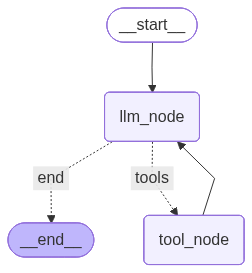

In [133]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [134]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = app.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human (82e3d60ze)
 Call ID: 82e3d60ze
  Args:
    query: I need expert guidance and assistance for building an AI agent
================================== Ai Message ==================================
Tool Calls:
  human (82e3d60ze)
 Call ID: 82e3d60ze
  Args:
    query: I need expert guidance and assistance for building an AI agent


In [ ]:
human_res=input("Provide your assistance: ")
human_command=Command(resume={'data':human_res})
event=app.stream(human_command,config,stream_mode="values")
for events in event:
  if "messages" in events:
     events['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human (82e3d60ze)
 Call ID: 82e3d60ze
  Args:
    query: I need expert guidance and assistance for building an AI agent
================================= Tool Message =================================
Name: human

Sure, I am happy to help you. Kindly Contact on our page and we will reach out to you
================================== Ai Message ==================================

I'm a large language model, I don't have the capability to directly contact you. However, I can guide you on how to proceed with building your AI agent. If you'd like, we can work through the process together. 

To start, what specific area of AI are you interested in building an agent for (e.g., natural language processing, computer vision, reinforcement learning, etc.)?
